# Deploying micro-mobility in a macro scale: how to leverage data science for higher micro-mobility impacts

In [ ]:
print('hello, jetbrains!')

hello, jetbrains!


# Important Info

This is a replicated notebook from a challenge done at [World Data League](https://worlddataleague.com/).

More information about this particular challenge and solution in  our teams [GitHub](https://github.com/holistic-insights/COMP-WDL2). You will also find our original notebook as well as the data used there (in the README file).

Check out more about Holin here: https://holistic-insights.github.io/

## 🎯 Challenge
*Optimization of soft-mobility drop-off points in the city of Porto*

## 👥 Authors
* Cristiana Carpinteiro
* Diogo Polónia
* João Afonso Pereira
* João Matos
* Patrícia Rocha

## 📋 Table of Contents<a name="top"></a>

[🔢 Setup & Data](#setup)

[💻 Development](#dev)

1. [EDA](#eda)
2. [Classification of Zones](#classification)
3. [Interpretability](#interpretability)
4. [Zone Scoring](#score)
5. [Drop-off Points Optimization](#opt_dist)
6. [Final Product](#product)
7. [Impact Estimation](#impact)
8. [Additional EDA](#more_eda)

## ⚙️ ***Setup*** <a name="setup"></a>

In [2]:
pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 518.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 37.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 36.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# System
import  os
import  time
import  warnings
from    tqdm     import tqdm
from    datetime import datetime
warnings.filterwarnings(action='ignore')

# DataFrames
import  pandas             as pd
import  geopandas          as gpd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Models
# noinspection PyUnresolvedReferences
# import  shap
# from    pulp                    import *
from    sklearn.preprocessing   import MinMaxScaler
from    sklearn.preprocessing   import StandardScaler
from    sklearn.model_selection import GridSearchCV
from    sklearn.model_selection import train_test_split
from    sklearn.inspection      import permutation_importance
from    sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, r2_score
from    sklearn.ensemble        import RandomForestClassifier
from    sklearn.ensemble        import RandomForestRegressor
from    sklearn.linear_model    import LogisticRegression


# Visualizations
import  seaborn              as sns
# import  gtfs_functions       as gtfs
import  matplotlib.pyplot    as plt
from    matplotlib           import rcParams
from    matplotlib           import pyplot as plt

# Others
import  json
import  numpy            as np
# import  haversine        as hs
from    shapely.ops      import split
from    shapely.geometry import LineString, MultiPolygon, Polygon
from    shapely.ops      import split

## 🔢 Data 

To build our solution, we used the following data:
* *[TIP Rodov and TIP Ferrov](https://wdl-data.fra1.digitaloceanspaces.com/porto/InterMunicipality.zip)* Entry and exit validation data (TIP) on road and rail public transport. These datasets were provided by WDL on the challenge 'Predicting the Flow of People for Public Transportation Improvements'.
* *[E-Scooter Transport Data and E-Scooter Location Data](https://wdl-data.fra1.digitaloceanspaces.com/porto/Soft-Mobility.zip)* List of E-Scooter parks and trips in Porto. Also provided by WDL.
* *[GTFS for Bus and Metro Stations](https://wdl-data.fra1.digitaloceanspaces.com/porto/Soft-Mobility.zip)* Public transport schedule data in General Transit Feed Specification (GTFS) format. Each file describes a particular aspect of transit information: stops, routes, frequencies, etc. We used this dataset to create features such as the proximity to stops, route diversity, and frequency.
* *[Bike Lanes](https://opendata.porto.digital/dataset/int-igvp-igvp-ciclovias)* This dataset contains all bike lanes in the city of Porto and was obtained from Open Data.

We also manually collected information on points of interest - tourist attractions, colleges, and public schools:
* *[Top 10 attractions](https://www.timeout.com/porto/attractions/portos-top-10-attractions)*
* *[University of Porto](https://www.up.pt/)*
* *[Public Schools](https://www.cm-porto.pt/sistema-educativo/rede-escolar-do-porto)*

## 💻 Development <a name="dev"></a>

### ***1. EDA*** <a name="eda"></a>

Our EDA had as objective to construct a set of features that would influence the microbility around Porto. 

We explored the datasets made available by the organization, but we also created our own features with data we found on Porto open data portal. 

Since we wanted to optimize the localization of the drop off points inside Porto, we divided the city into geographical zones and associated each localization to a curated set of features. 

We started by **splitting Porto into a simple grid** and studying the **geographical distribution** of factors that influence the usage of soft mobility by mapping them to each square of the grid.

#### 1.1 Building Porto's geographical grid
We decided to divide Porto into geographical with 6000 m2 to make the optimization of drop-off points easier. We will only consider the optimization of the drop-off points inside Porto city.

In [10]:
# Porto geojson, divided into parishes
porto = gpd.read_file('./porto.geojson')
porto.drop(['description', 'fill', 'video', 'website'], axis=1, inplace=True)

xmin, ymin, xmax, ymax = porto.total_bounds
wide, length = xmax - xmin, ymax - ymin

n_cols = 180
n_rows = 60

cols = list(np.arange(xmin, xmax+wide/n_cols, wide/n_cols))
rows = list(np.arange(ymin, ymax+length/n_rows, length/n_rows))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide/n_cols, y), (x+wide/n_cols, y+length/n_rows), (x, y+length/n_rows)]))

grid = gpd.GeoDataFrame({'geometry': polygons})
grid['boundaries'] = grid.boundary

for zone, name in zip(list(porto['geometry']), list(porto['title'])):
  grid.loc[grid.intersects(zone), 'zone'] = name

porto_grid = grid[grid['zone'].notna()].reset_index(drop=True)

**Visualize Optimization Grid:**

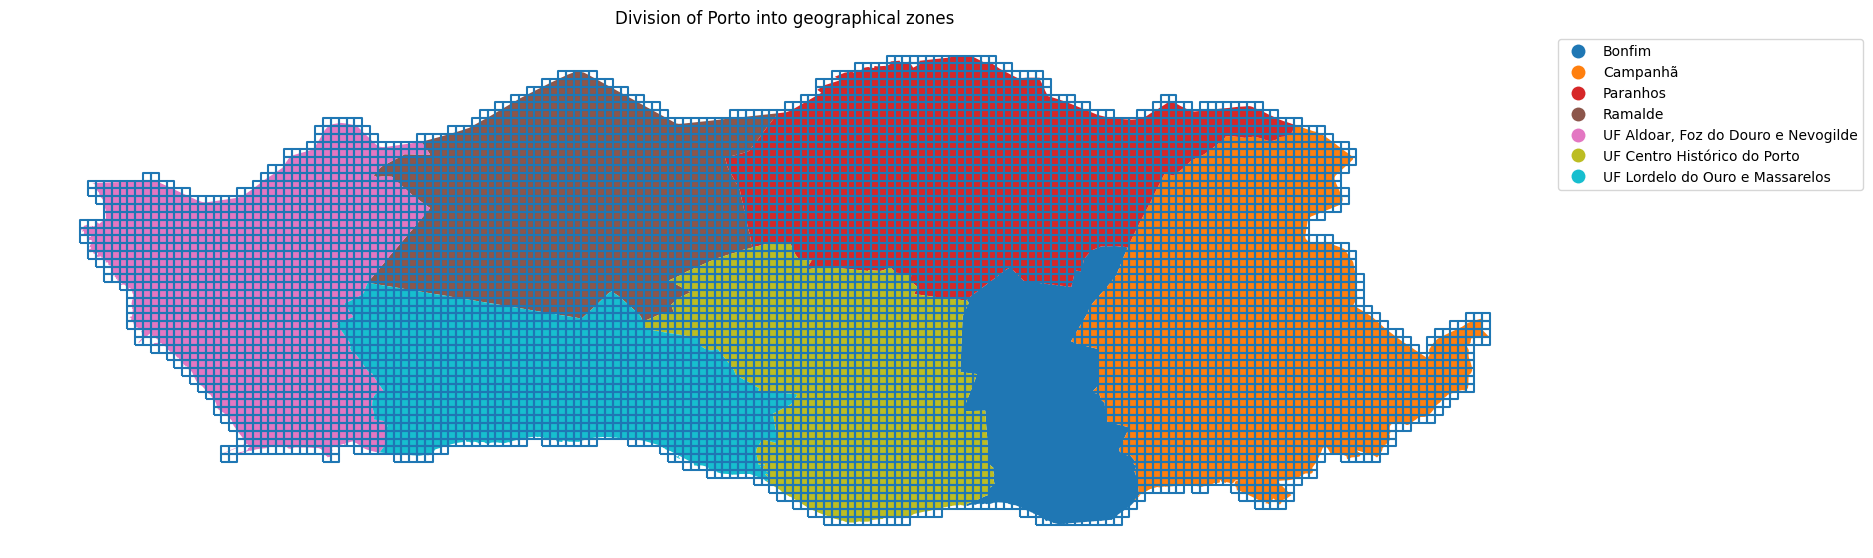

In [11]:
fig, ax = plt.subplots(figsize = (20,16))
porto.plot(column='title', legend=True,
           legend_kwds={'bbox_to_anchor': (1.2, 1)}, ax=ax)
porto_grid.boundary.plot(ax=ax)
ax.set_title('Division of Porto into geographical zones')
ax.set_axis_off()

#### 1.2 Public Transport Features (Bus)

We used the GTFS dataset made available by the organization to calculate the bus daily frequency and the number of unique lines that cross each optimization grid zone. We think that the proximity of transports is a deciding factor for the placement of the drop-off points. 

In [12]:
path = 'Data/gtfs_bus.zip'
# Read dataset
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path)

NameError: name 'gtfs' is not defined

Bus Frequencies: 

In [ ]:
cutoffs = [0,24] # get daily bus frequencies  
bus_stop_freq = gtfs.stops_freq(stop_times, stops, cutoffs = cutoffs)

# Plot bus stops
condition_dir= bus_stop_freq.dir_id == 'Inbound'
condition_window = bus_stop_freq.window == '0:00-24:00'
gdf = bus_stop_freq.loc[(condition_dir & condition_window), : ].reset_index()
gtfs.map_gdf(gdf=gdf, 
             variable='dir_id', 
             tooltip_var=['frequency', 'stop_id'],
             tooltip_labels = ['Frequency: ', 'Stop: '])

Number of unique bus lines passing by each bus stop:

In [ ]:
bus_stop_freq = bus_stop_freq.loc[condition_dir]
bus_stop_freq = bus_stop_freq[['stop_id','ntrips', 'frequency','max_trips', 'max_freq', 'stop_name', 'geometry']]

# Combine stop frequencies with stop_times dataset
stops_n_routes = stop_times[['stop_id', 'route_id', 'zone_id']]
stops_n_routes = stops_n_routes.drop_duplicates()
stops_n_routes = stops_n_routes.groupby('stop_id').count().sort_values(by='route_id',ascending=False)
bus_stop_freq = bus_stop_freq.merge(stops_n_routes, on='stop_id').rename(columns={'route_id':'number_of_routes'}).drop(columns='zone_id').set_index('stop_id')

Optimization Grid Feature: **Distance to nearest bus stop** 

In [ ]:
all_bus_stop_ids = dict()
nearest_stop_ids = dict()

for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  count = 0
  stop_ids = []
  center = zone.geometry.centroid
  min_distance = 1e20
  nearest_stop_id = ''
  for stop in bus_features_inside_porto.itertuples():
    # Calculate distance to nearest stop 
    distance_to_stop = center.distance(stop.geometry)
    if distance_to_stop < min_distance:
      min_distance = distance_to_stop
      nearest_stop_id = stop.Index

    # find stops inside each optimization grid zone
    if zone.geometry.contains(stop.geometry):
      count += 1
      stop_ids.append(stop.Index)

  porto_grid.loc[idx, 'n_bus'] = count
  all_bus_stop_ids[idx] = stop_ids
  nearest_stop_ids[idx] = nearest_stop_id
  porto_grid.loc[idx, 'dist_nearest_bus'] = min_distance

Optimization Grid Feature: **Number of unique routes the cross each zone**

In [ ]:
for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  if zone.n_bus == 0:
    porto_grid.loc[idx,'n_bus_trips'] = bus_features_inside_porto.loc[nearest_stop_ids[idx], 'ntrips']
    porto_grid.loc[idx,'n_bus_routes'] = bus_features_inside_porto.loc[nearest_stop_ids[idx], 'number_of_routes']
  else:
    porto_grid.loc[idx,'n_bus_trips'] = bus_features_inside_porto.loc[all_bus_stop_ids[idx], 'ntrips'].max()
    porto_grid.loc[idx,'n_bus_routes'] = bus_features_inside_porto.loc[all_bus_stop_ids[idx], 'number_of_routes'].max()
# Drop auxiliary features
porto_grid.drop(['boundaries', 'zone'], axis=1, inplace=True)

#### 1.3 Public Tranport Features (Metro)

In [ ]:
path = 'Data/gtfs_metro.zip'
# Read dataset
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path)

# Metro frequencies:

cutoffs = [0,24] # get daily metro frequencies  
metro_stop_freq = gtfs.stops_freq(stop_times, stops, cutoffs = cutoffs)

# Plot bus stops
condition_dir= metro_stop_freq.dir_id == 'Inbound'
condition_window = metro_stop_freq.window == '0:00-24:00'
gdf = metro_stop_freq.loc[(condition_dir & condition_window), : ].reset_index()
gtfs.map_gdf(gdf=gdf, 
             variable='dir_id', 
             tooltip_var=['frequency', 'stop_id'],
             tooltip_labels = ['Frequency: ', 'Stop: '])

### Number of unique metro lines passing by each metro stop:

metro_stop_freq = metro_stop_freq.loc[condition_dir]
metro_stop_freq = metro_stop_freq[['stop_id','ntrips', 'frequency','max_trips', 'max_freq', 'stop_name', 'geometry']]

# Combine stop frequencies with stop_times dataset
stops_n_routes = stop_times[['stop_id', 'route_id', 'zone_id']]
stops_n_routes = stops_n_routes.drop_duplicates()
stops_n_routes = stops_n_routes.groupby('stop_id').count().sort_values(by='route_id',ascending=False)

metro_stop_freq = metro_stop_freq.merge(stops_n_routes, on='stop_id').rename(columns={'route_id':'number_of_routes'}).drop(columns='zone_id')

### Optimization Grid Feature: Distance to nearest Metro stop

all_metro_stop_ids = dict()
nearest_stop_ids = dict()

for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  count = 0
  stop_ids = []
  center = zone.geometry.centroid
  min_distance = 1e20
  nearest_stop_id = ''
  for stop in metro_features_inside_porto.itertuples():
    # Calculate distance to nearest stop 
    distance_to_stop = center.distance(stop.geometry)
    if distance_to_stop < min_distance:
      min_distance = distance_to_stop
      nearest_stop_id = stop.Index

    # find stops inside each optimization grid zone
    if zone.geometry.contains(stop.geometry):
      count += 1
      stop_ids.append(stop.Index)

  porto_grid.loc[idx, 'n_metro'] = count
  all_metro_stop_ids[idx] = stop_ids
  nearest_stop_ids[idx] = nearest_stop_id
  porto_grid.loc[idx, 'dist_nearest_metro'] = min_distance

### Optimization Grid Features: Number of unique routes the cross each zone & Number of trips made

for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
    porto_grid.loc[idx,'n_metro_trips'] = metro_features_inside_porto.loc[nearest_stop_ids[idx], 'ntrips']
    porto_grid.loc[idx,'n_metro_routes'] = metro_features_inside_porto.loc[nearest_stop_ids[idx], 'number_of_routes']

#### 1.4 Bicyle Paths Features (distance to nearest path)

In [ ]:
cycle_paths = gpd.read_file('Data/ciclovias.geojson')

# Plot cycle paths
fig, ax = plt.subplots()
porto.boundary.plot(ax=ax)
cycle_paths.plot(column='estado_realiza', legend=True, cmap='Accent', ax=ax)
ax.set_axis_off()
ax.set_title('Porto cycling paths')

# Exclude cycle paths that are still being planned
cycle_paths = cycle_paths[cycle_paths['estado_realiza'] == 'exec']

distance_to_nearest_cycle_path = []
for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  center = zone.geometry.centroid
  min_distance = 1e20
  for path in cycle_paths.itertuples():
    distance_to_path = center.distance(path.geometry)
    if distance_to_path < min_distance:
      min_distance = distance_to_path
  porto_grid.loc[idx, 'dist_nearest_cycle_path'] = min_distance

#### 1.5  Points of Interest Features (Distance to nearest PoI)

The localization of the nearest points of interest around porto, such as turistic attractions and schools, should have an impact on the decision about the localization of the drop-off points.

#### 1.5.1 Schools and Universities
We believe that students can take advantage of micromobility services, so we considered the distance to schools and universities as a feature.

In [ ]:
# The University of Porto consists of 14 colleges 
# spread across three university campuses
df = pd.DataFrame(
    {
        'school': ['Arquitetura', 'Belas Artes', 'Ciências', 'Ciências Biomédicas', 'Ciências da Nutrição e da Alimentação', 'Desporto', 'Direito', 'Economia', 'Engenharia', 'Farmácia', 'Letras', 'Medicina', 'Medicina Dentária', 'Psicologia e Ciências da Educação'],
        'latitude': [41.1504, 41.1457, 41.1528, 41.1475, 41.1529, 41.1783, 41.1525, 41.1756, 41.1780, 41.1476, 41.1505, 41.1791, 41.1741, 41.1756],
        'longitude': [-8.6362, -8.6007, -8.6375, -8.6178, -8.6382, -8.6019, -8.6163, -8.5983, -8.5980, -8.6239, -8.6329, -8.5993, -8.6029, -8.6039]
    }
)
colleges_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Public schools in Porto
df = pd.DataFrame(
    {
        'school': ['Agrupamento de Escolas Alexandre Herculano', 'Agrupamento de Escolas António Nobre', 'Agrupamento de Escolas Aurélia de Sousa', 'Agrupamento de Escolas Carolina Michaëlis', 'Agrupamento de Escolas Clara de Resende', 'Agrupamento de Escolas do Cerco do Porto', 'Agrupamento de Escolas do Viso', 'Agrupamento de Escolas Eugénio de Andrade', 'Agrupamento de Escolas Fontes Pereira de Melo', 'Agrupamento de Escolas Garcia de Orta', 'Agrupamento de Escolas Infante D. Henrique', 'Agrupamento de Escolas Leonardo Coimbra Filho', 'Agrupamento de Escolas Manoel de Oliveira', 'Agrupamento de Escolas Pêro Vaz de Caminha', 'Agrupamento de Escolas Rodrigues de Freitas'],
        'latitude': [41.148893, 41.167882, 41.160291, 41.159521, 41.162665, 41.163339, 41.178596, 41.169974, 41.164180, 41.162557, 41.152833, 41.157360, 41.169042, 41.177620, 41.155673],
        'longitude': [-8.594657, -8.601278, -8.599571, -8.622263, -8.643622, -8.569486, -8.638440, -8.601917, -8.643250, -8.668517, -8.624802, -8.653965, -8.665871, -8.615622, -8.623161]
    }
)
schools_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

final_education_gdf = pd.concat([colleges_gdf, schools_gdf], axis=0).reset_index(drop=True)

### Calculate distance of optimization grid points to nearest schools and universities:

distances = []
for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  center = zone.geometry.centroid
  min_distance = 1e20
  for school in final_education_gdf.itertuples():
    distance_to_school = center.distance(school.geometry)
    if distance_to_school < min_distance:
        min_distance = distance_to_school
  porto_grid.loc[idx,'dist_nearest_school'] = min_distance

### 1.5.2 Turistic Attractions
Turists are one of the most active users of scooters, therefore, we considered the distance o the nearest turistic attraction an important factor to decide the localization of drop-off points

In [ ]:
# Porto’s top 10 attractions according to TimeOut
# including monuments, gardens, historic buildings, bookshops
# Source: https://www.timeout.com/porto/attractions/portos-top-10-attractions
df = pd.DataFrame(
    {
        'attraction': ['Clérigos Tower', 'Crystal Palace Gardens', 'Serra do Pilar', 'Porto Wine Cellars', 'Livraria Lello', 'Porto Cathedral', 'São Bento Train Station', 'Foz', 'Ribeira', 'Marés Swimming Pool'],
        'latitude': [41.1458, 41.1483, 41.1379, 41.1377, 41.1466, 41.1428, 41.1456, 41.15, 41.1404, 41.1927],
        'longitude': [-8.6140, -8.6256, -8.6082, -8.6123, -8.6147, -8.6113, -8.6103, -8.667, -8.6130, -8.7075],
    }
)

attractions_gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df.longitude, df.latitude))

distances = []
for idx, zone in tqdm(porto_grid.iterrows(),total = porto_grid.shape[0]):
  center = zone.geometry.centroid
  min_distance = 1e20
  for attraction in attractions_gdf.itertuples():
    distance_to_school = center.distance(school.geometry)
    if distance_to_school < min_distance:
        min_distance = distance_to_school
  porto_grid.loc[idx,'dist_nearest_attraction'] = min_distance

#### 1.6 Ticket Validations (metro, train and bus)   
The ticket validation data can tell us which stops are being used most and a general sense of the geographical flow of people around Porto  

In [ ]:
## Get list of validations of Metro & Bus separatately

path = r'..\\data\\InterMunicipality\\TIP'
folders = [f for f in os.listdir(path) if '.DS_' not in f]
files_ferr = []
files_rodo = []

for fo in folders:
    
    complete_path = os.path.join(path, fo)
    temp = os.listdir(complete_path)
    
    filename = [f for f in temp if 'ferrov' in f.lower()][0]
    files_ferr.append(os.path.join(complete_path, filename))
    
    filename = [f for f in temp if 'rodov' in f.lower()][0]   
    files_rodo.append(os.path.join(complete_path, filename))

## METRO & TRAIN
### Read all file by file, group by stop and get the average validations per day.
data = []

for i, file in enumerate(files_ferr):
    df = pd.read_excel(file)
    
    est_zone = df[['Est/Op', 'Zona']].copy()
    est_zone = est_zone.groupby('Est/Op').max().reset_index()

    df_ = df.groupby(['Est/Op', 'Ano', 'Mês', 'Dia']).sum()[['Validações']].reset_index()

    df_['Date'] = df_.apply(lambda row: datetime.datetime(row['Ano'], row['Mês'], row['Dia']), axis=1)
    df_ = df_.drop(columns=['Ano', 'Mês', 'Dia'])

    df_ = df_.groupby('Est/Op').mean().reset_index()
    df_final = df_.merge(est_zone)
    
    data.append(df_final)
    
data = pd.concat(data, ignore_index=True)
data = data.groupby('Est/Op').mean().reset_index()
data_ferrov = data.merge(est_zone).drop(columns=['Zona'])
data_ferrov.sort_values(by='Validações', ascending=False)

# Trindade, Casa da Música, Campanhã and São Bento have the highest number of validations from all metro stops, which makes sense for anyone that lives in Porto.

## BUS
## Read all file by file, group by stop and get the average validations per day.
data = []

for i, file in enumerate(files_rodo):
    df = pd.read_excel(file)
    df = df[df['Validações'].apply(lambda x: isinstance(x, (int, np.int64)))]
    df['Validações'] = df['Validações'].astype('int')

    est_zone = df[['Paragem', 'Zona']].copy()
    est_zone = est_zone.groupby('Paragem').max().reset_index()

    df_ = df.groupby(['Paragem', 'Ano', 'Mês', 'Dia']).sum()[['Validações']].reset_index()

    df_['Date'] = df_.apply(lambda row: datetime.datetime(row['Ano'], row['Mês'], row['Dia']), axis=1)
    df_ = df_.drop(columns=['Ano', 'Mês', 'Dia'])

    df_ = df_.groupby('Paragem').mean().reset_index()
    df_final = df_.merge(est_zone)
    
    data.append(df_final)
    
data = pd.concat(data, ignore_index=True)
data = data.groupby('Paragem').mean().reset_index()
data_rodov = data.merge(est_zone)
data_rodov.sort_values(by='Validações', ascending=False)
# Areosa, Campo 24 de Agosto, Casa da Música, Marquês and Aliados have the highest number of validations from all bus stops, which also makes completely sense for anyone that knows Porto.

**Join validation datasets with stops' geometry**

*Metro*

There were some inconsistencies between the metro stops names of the grid and the stops names of the validation data (for example "Senhora da Hora" and "Sª da Hora"), so the CSV file previously generated ('validation_ferrov.csv') was manually checked and all inconsistent names were changed directly in Excel. The resulting file was saved with the name 'validation_ferrov_fixed.csv'.

In [ ]:
path = 'validation_ferrov_fixed.csv'
validations = pd.read_csv(path)
validations = validations.rename(columns={'Est/Op': 'stop_name', 'Validações': 'validations'})

metro_stops = metro_features_inside_porto[['stop_id', 'stop_name', 'geometry']]
print("Number of stops in grid =", len(metro_stops))
print("Number of stops in validations =", len(validations))

Number of stops in grid = 83
Number of stops in validations = 166


Merge validations with grid (right merge to ensure all stops in grid are maintained).

In [ ]:
validations_metro = validations.merge(metro_stops, on='stop_name', how='right')
validations_metro['validations'] = validations_metro['validations'].fillna((validations_metro['validations'].mean()))
validations_metro[['stop_name', 'validations', 'geometry']].to_csv('validations_ferrov_final.csv')
validations_metro[['stop_name', 'validations', 'geometry']].head(3)

,stop_name,validations,geometry
0,Hospital Pedro Hispano,648.217491,POINT (-8.666232 41.180381)
1,Senhor de Matosinhos,190.241544,POINT (-8.685123 41.188205)
2,Mercado,683.241427,POINT (-8.693391 41.187484)


                stop_name  validations                     geometry
0  Hospital Pedro Hispano   648.217491  POINT (-8.666232 41.180381)
1    Senhor de Matosinhos   190.241544  POINT (-8.685123 41.188205)
2                 Mercado   683.241427  POINT (-8.693391 41.187484)

*Bus*

In [ ]:
path = 'validation_rodov.csv'
validations = pd.read_csv(path)
validations = validations.rename(columns={'Paragem': 'stop_name', 'Validações': 'validations'})

bus_stops = bus_features_inside_porto[['stop_id', 'stop_name', 'geometry']]

print("Number of stops in grid =", len(bus_stops))
print("Number of stops in validations =", len(validations))

Number of stops in grid = 1475
Number of stops in validations = 1255


Merge validations with grid (right merge to ensure all stops in grid are maintained).

In [ ]:
validations_bus = validations.merge(bus_stops, on='stop_name', how='right')
validations_bus['validations'] = val_data_bus['validations'].fillna((validations_bus['validations'].mean()))
validations_bus[['stop_name', 'validations', 'geometry']].to_csv('validations_rodov_final.csv')
validations_bus[['stop_name', 'validations', 'geometry']].head(3)

,stop_name,validations,geometry
0,CHÃO VERDE,90.287013,POINT (-8.55571114977721 41.1739072361269)
1,CHÃO VERDE,90.287013,POINT (-8.55626376068252 41.172932562849)
2,TRINDADE,1586.119444,POINT (-8.60958703096252 41.1516948699702)


    stop_name  validations                                    geometry
0  CHÃO VERDE    90.287013  POINT (-8.55571114977721 41.1739072361269)
1  CHÃO VERDE    90.287013   POINT (-8.55626376068252 41.172932562849)
2    TRINDADE  1586.119444  POINT (-8.60958703096252 41.1516948699702)

Both datasets (metro and bus) will be merged with the grid of Porto, alowing the visualization of the geographical distribution of the validation data (flow of people in public transports) across the city.

**Associate validations data to loalizations in the optimzation grid**

Plot bus validations:

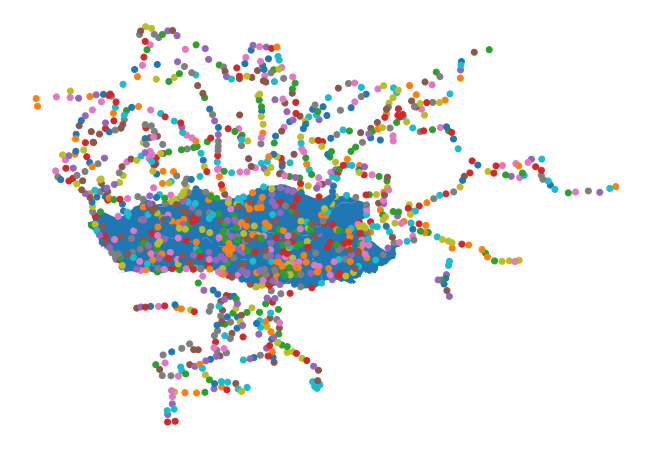

<Figure size 1152x576 with 1 Axes>

In [ ]:
fig, ax = plt.subplots()
porto.plot(ax=ax)
validations_bus.plot(column='stop_name', ax=ax)
ax.set_axis_off()

Associate validation of bus tickets to the optimization of the grid

In [ ]:
validations = []
for zone in porto_grid.itertuples():
  stops = []
  for stop in validations_bus.itertuples():
    if zone.geometry.contains(stop.geometry):
      stops.append(stop.stop_name)

  center = zone.geometry.centroid
  if len(stops) == 0:
    min_distance = 1e20
    name = ''
    for stop in validations_bus.itertuples():
      distance_to_stop = center.distance(stop.geometry)
      if distance_to_stop < min_distance:
        min_distance = distance_to_stop
        name = stop.stop_name

    validations.append(validations_bus[validations_bus.stop_name == name].iloc[0]['validations'])
  else:
    validations.append(validations_bus[validations_bus.stop_name.isin(stops)]['validations'].max())

porto_grid['validations_bus'] = validations

Associate validation of metro tickets to the optimization of the grid

In [ ]:
validations = []
for zone in porto_grid.itertuples():
  stops = []
  for stop in validations_metro.itertuples():
    if zone.geometry.contains(stop.geometry):
      stops.append(stop.stop_name)

  center = zone.geometry.centroid
  if len(stops) == 0:
    min_distance = 1e20
    name = ''
    for stop in validations_metro.itertuples():
      distance_to_stop = center.distance(stop.geometry)
      if distance_to_stop < min_distance:
        min_distance = distance_to_stop
        name = stop.stop_name
    validations.append(validations_metro[validations_metro.stop_name == name].iloc[0]['validations'])
  else:
    validations.append(validations_metro[validations_metro.stop_name.isin(stops)]['validations'].max())
    
porto_grid['validations_metro'] = validations

#### 1.7 Process soft-mobility trips datastet (E-Scooter OD)

We used this dataset to find out the current softmobility flow: the number of trips per zone in the optimization grid

Convert longitude and latitude into geopandas geometry points

In [ ]:
df = pd.read_csv('Data/wdl_od_view.csv')
geometry = gpd.points_from_xy(df['lng'], df['lat'])
df['geometry'] = geometry
df.head(1)

,recorded,id,device_id,timestamp,event_types,vehicle_state,trip_state,telemetry_timestamp,trip_id,lat,lng,geometry
0,1634809115769,1,a7990baa-909e-42ed-8546-a2a9d2e42b3c,1634734083000,{trip_leave_jurisdiction},elsewhere,NaN,1634734079000,6e073f7f-b955-4033-b7bd-6237faa51507,41.147263,-8.674807,POINT (-8.67481 41.14726)


        recorded  id                             device_id      timestamp  \
0  1634809115769   1  a7990baa-909e-42ed-8546-a2a9d2e42b3c  1634734083000   

                 event_types vehicle_state  trip_state  telemetry_timestamp  \
0  {trip_leave_jurisdiction}     elsewhere         NaN        1634734079000   

                                trip_id        lat       lng  \
0  6e073f7f-b955-4033-b7bd-6237faa51507  41.147263 -8.674807   

                    geometry  
0  POINT (-8.67481 41.14726)  

**Consider only the points where trips were started**

In [ ]:
df = df.loc[df['event_types'] == '{trip_start}']
df = df[['timestamp', 'geometry']].reset_index()
df = df.rename(columns={'index':'trip_id'})
df = df.dropna(subset=['geometry'])
print("Number of rows:", len(df))
print("Number of unique trips:", len(df['trip_id'].unique()))
df.head(3)

Number of rows: 71909
Number of unique trips: 71909



,trip_id,timestamp,geometry
0,2,1635282790000,POINT (-8.66511 41.14802)
1,4,1635282728000,POINT (-8.61231 41.14512)
2,7,1635282805000,POINT (-8.61124 41.17267)


   trip_id      timestamp                   geometry
0        2  1635282790000  POINT (-8.66511 41.14802)
1        4  1635282728000  POINT (-8.61231 41.14512)
2        7  1635282805000  POINT (-8.61124 41.17267)

Define the zone corresponding to all soft-mobility trips starts

In [ ]:
for zone in tqdm(porto_grid.itertuples(), total=len(porto_grid)):
    for trip in df.itertuples():
        try:
            if zone.geometry.contains(trip.geometry):
                df.loc[df['trip_id'] == trip.trip_id, 'zone'] = zone[0]
        except:
            pass

Convert timestamps into *dates*

In [ ]:
df = df.dropna()
df['timestamp'] = df['timestamp'].apply(lambda x: int(str(int(x))[:-3]))
df['datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
df['date'] = df['datetime'].apply(lambda x: x.date())

Count trips per zone

In [ ]:
df = df[['zone', 'date']]
df = df.groupby('zone').count()
df = df.reset_index().rename(columns={'date': 'n_trips_start'})
df['zone'] = df['zone'].apply(lambda x: int(x))
df.head(3)

,zone,n_trips_start
0,6,2
1,12,80
2,13,230


   zone  n_trips_start
0     6              2
1    12             80
2    13            230

Associate trips per zone with optimization grid

In [ ]:
porto_grid = porto_grid.drop(columns=['Unnamed: 0']).reset_index().rename(columns={'index': 'zone'})

porto_grid_ = porto_grid.merge(df, on='zone', how='left')
porto_grid_['n_trips_start'] = porto_grid_['n_trips_start'].fillna(0)

print('Number of rows in grid =', len(porto_grid_))
porto_grid.head(2)

Number of rows in grid = 7496



,zone,geometry,n_bus,dist_nearest_bus,n_bus_routes,n_bus_trips,n_metro,dist_nearest_metro,n_metro_routes,n_metro_trips,dist_nearest_cycle_path,validations_bus,validations_metro,dist_nearest_school,dist_nearest_attraction
0,0,"POLYGON ((-8.69129 41.16747, -8.69052 41.16747...",0,0.001447,4,62,0,0.012536,1,1,0.001312,664.935714,1752.209843,0.023005,0.029836
1,1,"POLYGON ((-8.69129 41.16824, -8.69052 41.16824...",0,0.001648,4,62,0,0.011782,1,1,0.001452,664.935714,1752.209843,0.023194,0.029241


   zone                                           geometry  n_bus  \
0     0  POLYGON ((-8.69129 41.16747, -8.69052 41.16747...      0   
1     1  POLYGON ((-8.69129 41.16824, -8.69052 41.16824...      0   

   dist_nearest_bus  n_bus_routes  n_bus_trips  n_metro  dist_nearest_metro  \
0          0.001447             4           62        0            0.012536   
1          0.001648             4           62        0            0.011782   

   n_metro_routes  n_metro_trips  dist_nearest_cycle_path  validations_bus  \
0               1              1                 0.001312       664.935714   
1               1              1                 0.001452       664.935714   

   validations_metro  dist_nearest_school  dist_nearest_attraction  
0        1752.209843             0.023005                 0.029836  
1        1752.209843             0.023194                 0.029241  

Show current geographical distribution of soft-mobility trips' starting points

<AxesSubplot:>

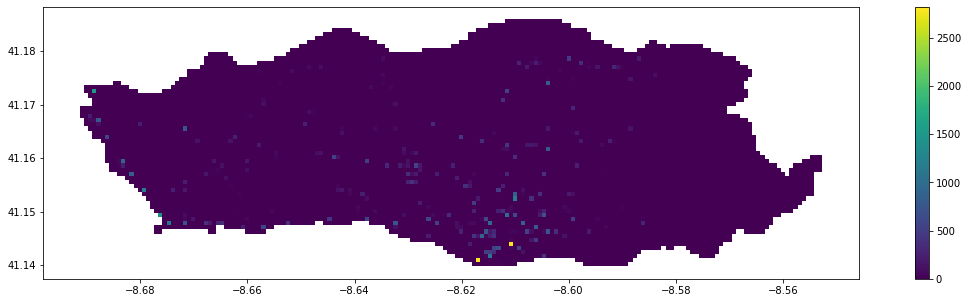

<Figure size 1440x360 with 2 Axes>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

porto_grid_.plot(column='n_trips_start', ax=ax, legend=True)
ax.set_title('Current localization of soft mobility starting points')

In [ ]:
porto_grid.head()

,geometry,n_bus,dist_nearest_bus,n_bus_routes,n_bus_trips,n_metro,dist_nearest_metro,n_metro_routes,n_metro_trips,dist_nearest_cycle_path,validations_bus,validations_metro,dist_nearest_school,dist_nearest_attraction
0,"POLYGON ((-8.69129 41.16747, -8.69052 41.16747...",0,0.001447,4,62,0,0.012536,1,1,0.001312,664.935714,1752.209843,0.023005,0.029836
1,"POLYGON ((-8.69129 41.16824, -8.69052 41.16824...",0,0.001648,4,62,0,0.011782,1,1,0.001452,664.935714,1752.209843,0.023194,0.029241
2,"POLYGON ((-8.69129 41.16901, -8.69052 41.16901...",0,0.002127,4,62,0,0.011029,1,1,0.001780,664.935714,1752.209843,0.023407,0.028611
3,"POLYGON ((-8.69052 41.16593, -8.68975 41.16593...",0,0.001493,2,93,0,0.013942,1,1,0.001339,664.935714,1752.209843,0.021940,0.028309
4,"POLYGON ((-8.69052 41.16670, -8.68975 41.16670...",0,0.001009,4,62,0,0.013178,1,1,0.000801,664.935714,1752.209843,0.022085,0.028759


                                            geometry  n_bus  dist_nearest_bus  \
0  POLYGON ((-8.69129 41.16747, -8.69052 41.16747...      0          0.001447   
1  POLYGON ((-8.69129 41.16824, -8.69052 41.16824...      0          0.001648   
2  POLYGON ((-8.69129 41.16901, -8.69052 41.16901...      0          0.002127   
3  POLYGON ((-8.69052 41.16593, -8.68975 41.16593...      0          0.001493   
4  POLYGON ((-8.69052 41.16670, -8.68975 41.16670...      0          0.001009   

   n_bus_routes  n_bus_trips  n_metro  dist_nearest_metro  n_metro_routes  \
0             4           62        0            0.012536               1   
1             4           62        0            0.011782               1   
2             4           62        0            0.011029               1   
3             2           93        0            0.013942               1   
4             4           62        0            0.013178               1   

   n_metro_trips  dist_nearest_cycle_path  validat

There is a notable high number of trips starting in Baixa and also a clear usage along the river in Foz.

**Find out current locations of dropoff points**

In [ ]:
f = open('Soft-Mobility/E-Scooter_Parks/e-scooter_parks.json')
parks = json.load(f)
attributes = parks['features'][0]['attributes']
geometry = parks['features'][0]['geometry']
aux_attributes = pd.DataFrame.from_dict(attributes, orient='index').T
aux_geometry =pd.DataFrame.from_dict(geometry, orient='index').T
aux = pd.concat([aux_attributes, aux_geometry], axis=1, join='inner')

for park in parks['features']:
    attributes = park['attributes']
    geometry = park['geometry']
    aux_attributes = pd.DataFrame.from_dict(attributes, orient='index').T
    aux_geometry =pd.DataFrame.from_dict(geometry, orient='index').T
    aux = pd.concat([aux_attributes, aux_geometry], axis=1, join='inner')
    parks_df = pd.concat([parks_df, aux])
parks_df.rename(columns={"x": "lng", "y": "lat"}, inplace=True )

stops_gdf = gpd.GeoDataFrame(
    parks_df, geometry=gpd.points_from_xy(parks_df.lng, parks_df.lat))

n_current_stops = len(pd.unique(stops_gdf['objectid_1']))

# See which points in stops_gdf are in each zone
counter = 0
total_zones = len(data)
start = time.time()
pts = stops_gdf.copy() 
# We're going to keep a list of how many points we find.
pts_in_polys = []
count= 0
# Loop over polygons with index i.
for i, poly in data.iterrows():

    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Add it to the list,
            pts_in_this_poly.append(pt.geometry)
            #pts = pts.drop([j])
            count+=1
    
    pts_in_polys.append(len(pts_in_this_poly))

    counter += 1
    end = time.time()
    elapsed = round((end - start)/60, 2)
    print(f'{counter} of {total_zones} zones iterated | {elapsed} min | Total time estimated: {round(elapsed/counter * total_zones, 2)} min', end = '\r')

# Add the number of points for each poly to the dataframe.
data['n_stops'] = gpd.GeoSeries(pts_in_polys)

print(f'Stops found: {dropoffs["n_stops"].sum()}')
# check max number of stops per zone currently
print(f'Max stops per zone: {dropoffs["n_stops"].max()}')

Stops found: 216
Max stops per zone: 2


Merge grid with number of drop-offs (stops) per zone

Text(0.5, 1.0, "Current locations of scooters' drop-off sites (number of drop-offs per zone)")

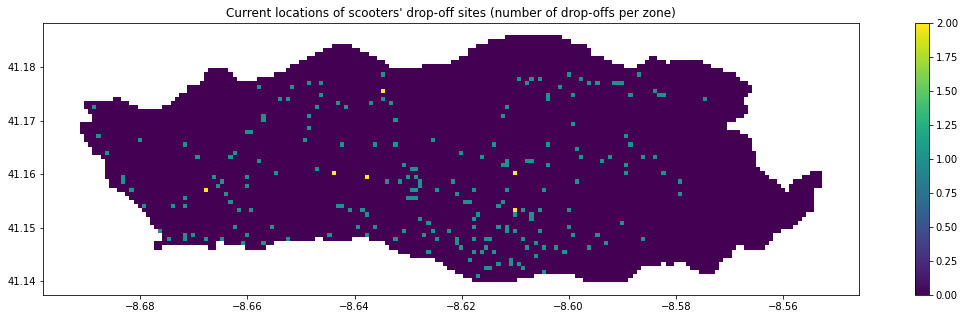

<Figure size 1440x360 with 2 Axes>

In [ ]:
data = data.merge(dropoffs, on='zone').rename(columns={'n_stops': 'num_dropoffs'})
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
data.plot(column='num_dropoffs', ax=ax, legend=True)
ax.set_title("Current locations of scooters' drop-off sites (number of drop-offs per zone)")

Check number of zones with 0, 1 and 2 drop-offs

In [ ]:
data['num_dropoffs'].value_counts()

0    7286
1     204
2       6
Name: num_dropoffs, dtype: int64

### ***2. Classification of number of trips per zone*** <a name="classification"></a>

The goal of this section is to create a model that can predict if a zone has high or low number of trips, giving the feature previously added to the grid dataset (distance to attractions, number of bus stops, etc.). The interpretability (feature importance) of this model will allow to understand the impact of this features in the population, that is, will allow to know better what factors make people use more soft-mobility solutions.

This information regarding the feature importance will allow the creation of a unique score per zone, which will be called the "probability of usage" score. This score will be a linear combination of the values of all features, with the coefficients being correlated to the importance of the features in the classification model.

**In order to avoid a bias in the classification because of the number of drop-offs (for example, a zone with two drop-offs has more tendency to have a higher number of trips because it has more scooters available there), the model will only use the 204 zones with 1 drop-off.**

In [ ]:
data = data.loc[data['num_dropoffs'] == 1]

To define the number of trips threshold that separates the two classes (0 - lower than threshold, 1 - higher than threshold), the median will be used.

In [ ]:
median_trips = data['n_trips_start'].median()
print("Median number of trips =", median_trips)

data['label'] = data['n_trips_start'].apply(lambda x: 1 if x > median_trips else 0)
print("\nLabels:")
data['label'].value_counts()

Median number of trips = 168.0

Labels:



1    102
0    102
Name: label, dtype: int64

Split between train and test datasets, and scale data.

In [ ]:
dataset = data.copy()
X = dataset.drop(columns=['label']).to_numpy()
y = dataset['label'].to_numpy()

features = dataset.drop(columns=['label']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Train and test a **Logistic Regression** model. The parameters will be optimized using a grid search with 5 fold cross validation and then tested separately using the independent test set.

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best validation score = 0.62


Test accuracy = 0.56





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
The max_iter was reached which means the coef_ did not converge


The max_iter was reached which means the coef_ did not converge





Text(33.0, 0.5, 'True label')

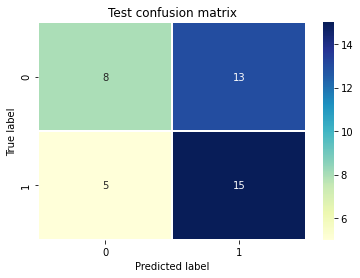

<Figure size 432x288 with 2 Axes>

In [ ]:
clf = LogisticRegression(random_state=0)

# Hyperparamater tunning
param_grid = {
    'penalty': ['l2', 'none'],                      
    'solver': ['lbfgs', 'sag', 'saga'],   
    'C': [0.1, 1, 10, 100]
}

cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1, scoring='accuracy')
cv.fit(X_train, y_train)

print("Best validation score = {:.2f}".format(cv.best_score_))

clf.set_params(**cv.best_params_)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Test accuracy = {:.2f}".format(test_acc))

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_title('Test confusion matrix')     
sns.heatmap(cm, linewidth=0.5, ax=ax, annot=True, cmap='YlGnBu', fmt='d')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

Train and test a **Random Forest** model. The parameters will be optimized using a grid search with 5 fold cross validation and then tested separately using the independent test set.

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


Best validation score = 0.70
Test accuracy = 0.66





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 859 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   36.4s finished
The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.





Text(33.0, 0.5, 'True label')

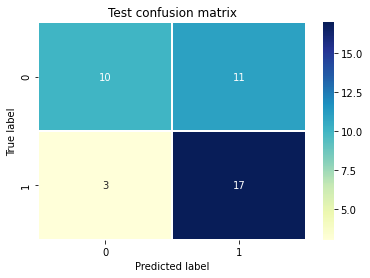

<Figure size 432x288 with 2 Axes>

In [ ]:
clf = RandomForestClassifier()

# Hyperparamater tunning
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 50, 100, 200]
}

cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1, scoring='accuracy')
cv.fit(X_train, y_train)

print("Best validation score = {:.2f}".format(cv.best_score_))

clf.set_params(**cv.best_params_)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Test accuracy = {:.2f}".format(test_acc))

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_title('Test confusion matrix')     
sns.heatmap(cm, linewidth=0.5, ax=ax, annot=True, cmap='YlGnBu', fmt='d')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

The best model is the Random Forest, so now the feature importance will be evaluated.

### ***3. Interpretability*** <a name="interpretability"></a>

Once the model was trained, we wanted to check which ones of our handcrafted features were most important. This will be important to optimize the localization of the drop-of points

,feature,importance
12,dist_nearest_attraction,0.219822
8,dist_nearest_cycle_path,0.128170
10,validations_metro,0.127098
11,dist_nearest_school,0.116380
3,n_bus_trips,0.094209
1,dist_nearest_bus,0.087915
9,validations_bus,0.084941
5,dist_nearest_metro,0.061713
7,n_metro_trips,0.033694
6,n_metro_routes,0.024702


                    feature  importance
12  dist_nearest_attraction    0.219822
8   dist_nearest_cycle_path    0.128170
10        validations_metro    0.127098
11      dist_nearest_school    0.116380
3               n_bus_trips    0.094209
1          dist_nearest_bus    0.087915
9           validations_bus    0.084941
5        dist_nearest_metro    0.061713
7             n_metro_trips    0.033694
6            n_metro_routes    0.024702
2              n_bus_routes    0.019333
0                     n_bus    0.002023
4                   n_metro    0.000000

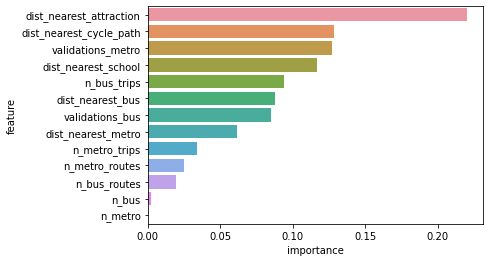

<Figure size 432x288 with 1 Axes>

In [ ]:
imp = pd.DataFrame({'feature': features, 'importance': clf.feature_importances_}).sort_values(by='importance', ascending=False)

fig, ax = plt.subplots()
sns.barplot(x='importance', y='feature', data=imp, ax=ax)

imp

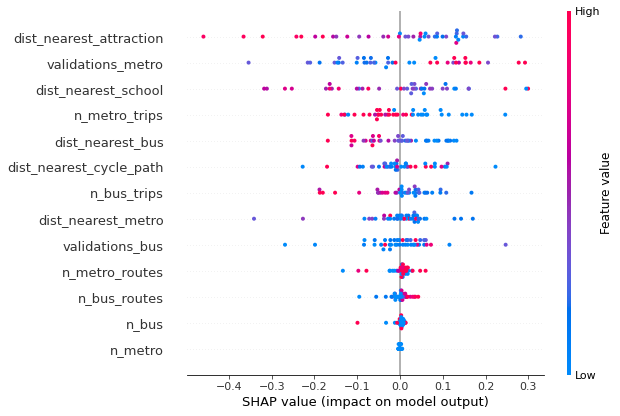

<Figure size 576x482.4 with 2 Axes>

In [ ]:
explainer = shap.KernelExplainer(cv.predict, data=X_test) 
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,  feature_names=features) 

The distance to attractions and to cycle paths, as well as the metro validations are the top 3 most important features. The first 2 features have, of course, a negative impact in the model, as a higher distance to these spots means a lower probability of usage of soft-mobility solutions by the population. On the other hand, the metro validations have a positive impact, as more people using the metro means that more people will probably use soft-mobility solutions near that metro stop. The signal of the impact is clearly observed and proved in the SHAP plot for most features, but as the number of points in the dataset is not very high (204 zones), some feature don't have a clear signal of impact in the SHAP plot. Therefore, the signal for each feature was manually chosen from its definition. 

The distances to attractions, to bus, to metro, to schools and to cycle paths have a negative impact, whereas the remaining feature have positive impact (for example, higher number of metro stops should impact positively the number of soft-mobility trips).

In [ ]:
feature_names = ['dist_nearest_attraction', 'dist_nearest_cycle_path', 'dist_nearest_school', 'validations_metro', 'validations_bus', 'dist_nearest_metro', 'n_bus_trips', 'dist_nearest_bus', 'n_bus_routes', 'n_metro_trips', 'n_metro_routes', 'n_bus', 'n_metro']
signal = [-1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1]

feature_signal = pd.DataFrame({'feature': feature_names, 'signal': signal})
imp = imp.merge(feature_signal, on='feature')
imp

,feature,importance,signal
0,dist_nearest_attraction,0.167538,-1
1,dist_nearest_metro,0.116106,-1
2,validations_metro,0.094208,1
3,dist_nearest_bus,0.093272,-1
4,dist_nearest_school,0.088690,-1
5,dist_nearest_cycle_path,0.084086,-1
6,n_metro_trips,0.077426,1
7,n_bus_trips,0.071967,1
8,validations_bus,0.067364,1
9,n_bus_routes,0.058320,1


                    feature  importance  signal
0   dist_nearest_attraction    0.167538      -1
1        dist_nearest_metro    0.116106      -1
2         validations_metro    0.094208       1
3          dist_nearest_bus    0.093272      -1
4       dist_nearest_school    0.088690      -1
5   dist_nearest_cycle_path    0.084086      -1
6             n_metro_trips    0.077426       1
7               n_bus_trips    0.071967       1
8           validations_bus    0.067364       1
9              n_bus_routes    0.058320       1
10           n_metro_routes    0.046463       1
11                    n_bus    0.034560       1
12                  n_metro    0.000000       1

As the coefficients are all below 1, the final score will have a very low value for all features, which makes it more difficult to visualize, so the importance will be scaled between 1 and 2 and then multiplied again by the signal.

In [ ]:
scaler = MinMaxScaler(feature_range=(1, 2))
imp_scaled = scaler.fit_transform(imp['importance'].to_numpy().reshape(imp['importance'].to_numpy().shape[0], 1))
imp['importance_scaled'] = imp_scaled
imp['coef_scaled'] = imp['importance_scaled'] * imp['signal']
imp.to_csv('coeffs_per_feature.csv', index=False)
imp

,feature,importance,signal,importance_scaled,coef_scaled
0,dist_nearest_attraction,0.167538,-1,2.000000,-2.000000
1,dist_nearest_metro,0.116106,-1,1.693014,-1.693014
2,validations_metro,0.094208,1,1.562308,1.562308
3,dist_nearest_bus,0.093272,-1,1.556718,-1.556718
4,dist_nearest_school,0.088690,-1,1.529373,-1.529373
5,dist_nearest_cycle_path,0.084086,-1,1.501891,-1.501891
6,n_metro_trips,0.077426,1,1.462141,1.462141
7,n_bus_trips,0.071967,1,1.429554,1.429554
8,validations_bus,0.067364,1,1.402082,1.402082
9,n_bus_routes,0.058320,1,1.348100,1.348100


                    feature  importance  signal  importance_scaled  \
0   dist_nearest_attraction    0.167538      -1           2.000000   
1        dist_nearest_metro    0.116106      -1           1.693014   
2         validations_metro    0.094208       1           1.562308   
3          dist_nearest_bus    0.093272      -1           1.556718   
4       dist_nearest_school    0.088690      -1           1.529373   
5   dist_nearest_cycle_path    0.084086      -1           1.501891   
6             n_metro_trips    0.077426       1           1.462141   
7               n_bus_trips    0.071967       1           1.429554   
8           validations_bus    0.067364       1           1.402082   
9              n_bus_routes    0.058320       1           1.348100   
10           n_metro_routes    0.046463       1           1.277329   
11                    n_bus    0.034560       1           1.206280   
12                  n_metro    0.000000       1           1.000000   

    coef_scaled  
0

### ***4. Create final score*** <a name="score"></a>

This score will be used to improve the localization of the drop-off points. 

First, the grid is read and all features are scaled (standard scaling).

In [ ]:
meta = grid[['zone', 'geometry']]
X = grid.drop(columns=['zone', 'geometry']).to_numpy()
features = grid.drop(columns=['zone', 'geometry']).columns.tolist()

scaler = StandardScaler()
X = scaler.fit_transform(X)

grid = pd.DataFrame(X, columns=features)
grid = pd.concat([meta, grid], axis=1)
grid.head(2)

,zone,geometry,n_bus,dist_nearest_bus,n_bus_routes,n_bus_trips,n_metro,dist_nearest_metro,n_metro_routes,n_metro_trips,dist_nearest_cycle_path,validations_bus,validations_metro,dist_nearest_school,dist_nearest_attraction
0,0,"POLYGON ((-8.691288 41.16747220000001, -8.6905...",-0.273462,-0.041708,0.713382,-0.372712,-0.057847,0.423623,-0.979388,-1.116576,-0.915643,1.772261,-0.238119,3.436571,0.511439
1,1,"POLYGON ((-8.691288 41.16824148333335, -8.6905...",-0.273462,0.175245,0.713382,-0.372712,-0.057847,0.315135,-0.979388,-1.116576,-0.889588,1.772261,-0.238119,3.479121,0.463460


   zone                                           geometry     n_bus  \
0     0  POLYGON ((-8.691288 41.16747220000001, -8.6905... -0.273462   
1     1  POLYGON ((-8.691288 41.16824148333335, -8.6905... -0.273462   

   dist_nearest_bus  n_bus_routes  n_bus_trips   n_metro  dist_nearest_metro  \
0         -0.041708      0.713382    -0.372712 -0.057847            0.423623   
1          0.175245      0.713382    -0.372712 -0.057847            0.315135   

   n_metro_routes  n_metro_trips  dist_nearest_cycle_path  validations_bus  \
0       -0.979388      -1.116576                -0.915643         1.772261   
1       -0.979388      -1.116576                -0.889588         1.772261   

   validations_metro  dist_nearest_school  dist_nearest_attraction  
0          -0.238119             3.436571                 0.511439  
1          -0.238119             3.479121                 0.463460  

The final score corresponds to a linear combination between all features (using the coefficients from the feature importance).

In [ ]:
def create_score(row):
    score = 0
    for col in features:
        
        coef = imp.loc[imp['feature'] == col]['coef_scaled'].item()
        score += (row[col] * coef)
        
    return score

In [ ]:
grid['score'] = grid.apply(create_score, axis=1)
grid.head(2)

,zone,geometry,n_bus,dist_nearest_bus,n_bus_routes,n_bus_trips,n_metro,dist_nearest_metro,n_metro_routes,n_metro_trips,dist_nearest_cycle_path,validations_bus,validations_metro,dist_nearest_school,dist_nearest_attraction,score
0,0,"POLYGON ((-8.691288 41.16747220000001, -8.6905...",-0.273462,-0.041708,0.713382,-0.372712,-0.057847,0.423623,-0.979388,-1.116576,-0.915643,1.772261,-0.238119,3.436571,0.511439,-6.285322
1,1,"POLYGON ((-8.691288 41.16824148333335, -8.6905...",-0.273462,0.175245,0.713382,-0.372712,-0.057847,0.315135,-0.979388,-1.116576,-0.889588,1.772261,-0.238119,3.479121,0.463460,-6.447636


   zone                                           geometry     n_bus  \
0     0  POLYGON ((-8.691288 41.16747220000001, -8.6905... -0.273462   
1     1  POLYGON ((-8.691288 41.16824148333335, -8.6905... -0.273462   

   dist_nearest_bus  n_bus_routes  n_bus_trips   n_metro  dist_nearest_metro  \
0         -0.041708      0.713382    -0.372712 -0.057847            0.423623   
1          0.175245      0.713382    -0.372712 -0.057847            0.315135   

   n_metro_routes  n_metro_trips  dist_nearest_cycle_path  validations_bus  \
0       -0.979388      -1.116576                -0.915643         1.772261   
1       -0.979388      -1.116576                -0.889588         1.772261   

   validations_metro  dist_nearest_school  dist_nearest_attraction     score  
0          -0.238119             3.436571                 0.511439 -6.285322  
1          -0.238119             3.479121                 0.463460 -6.447636  

**Plot the final score**

Text(0.5, 1.0, 'Final score per zone')

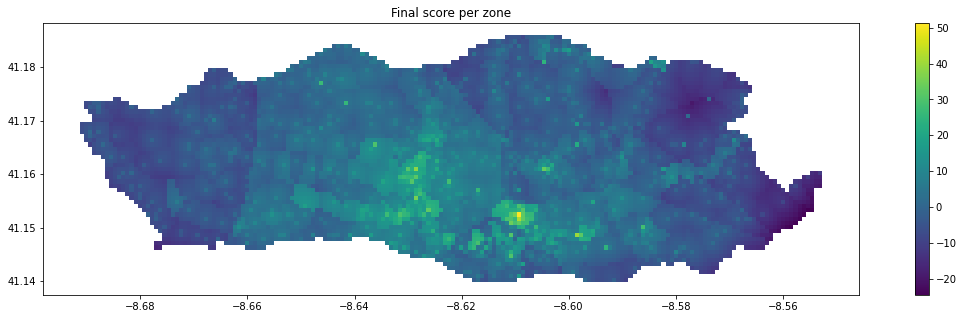

<Figure size 1440x360 with 2 Axes>

In [ ]:
score_grid['geometry'] = gpd.GeoSeries.from_wkt(grid['geometry'])
score_grid = gpd.GeoDataFrame(grid, geometry='geometry')
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
grid.plot(column='score', ax=ax, legend=True)
ax.set_title("Final score per zone")

There is a considerable number of zones with very high score in Baixa, as expected, but also in some interesting isolated areas which represent the other features apart from attractions, like public transports and schools.

### ***5. Improving the localization of drop-off points*** <a name="improve"></a>
We'll order the zones form highest score to lowest and add one drop off to each zone. 

Why 1 drop off per zone?
Currently 204 of te 210 zones with stops only have 1 stop

Total New Stops: 210
Zones with stops: 210
Max stops per zone: 1
---------------------
# Stops removed: 186
# Stops mantained: 24
# New Stops: 186




<AxesSubplot:>

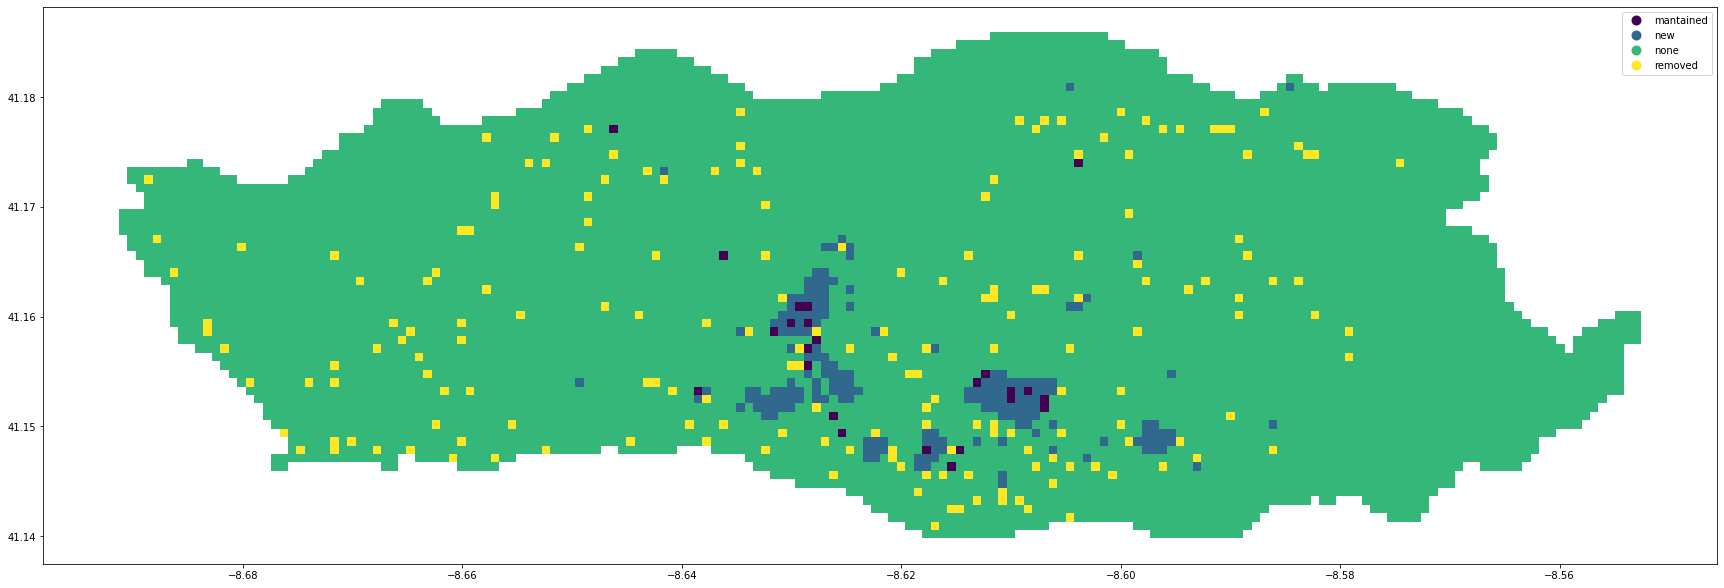

<Figure size 2160x1440 with 1 Axes>

In [ ]:
score_grid = score_grid[['zone', 'geometry', 'score']]

# add stops by highest to lowest score
max_stops = 210
score_grid = score_grid.sort_values(by='score', ascending=False)
counter = 0
stops = []
for i, row in score_grid.iterrows():
    if counter < max_stops:
        stops.append(1)
        counter += 1
    else:
        stops.append(0)
score_grid['new_stops'] = stops

# Checks
print(f'Total New Stops: {score_grid["new_stops"].sum()}')
print(f'Zones with stops: {score_grid[score_grid["new_stops"]>0]["new_stops"].count()}')
print(f'Max stops per zone: {score_grid["new_stops"].max()}')

# merge new stops with old stops
score_grid = score_grid.merge(data[['zone', 'n_stops']], how='left', on='zone')

# see differences
types = []
for i, row in score_grid.iterrows():
    if row['n_stops'] == 0:
        if row['new_stops'] == 1:
            types.append('new')
        else:
            types.append('none')
    else:
        if row['new_stops'] == 1:
            types.append('mantained')
        else:
            types.append('removed')
score_grid['difference'] = types
score_grid[score_grid['difference'] == 'new']['difference'].count()

# plot differences
print("---------------------")
print(f"# Stops removed: {score_grid[score_grid['difference'] == 'removed']['difference'].count()}")
print(f"# Stops mantained: {score_grid[score_grid['difference'] == 'mantained']['difference'].count()}")
print(f"# New Stops: {score_grid[score_grid['difference'] == 'new']['difference'].count()}")

score_grid.plot(figsize=(30,20), column="difference", cmap="viridis", categorical=True, legend = True)

**Conclusion:**
Drop-off zones were centered in the cities downtown, leaving little to no stops in the city viscinities, meaning that we need to add restricitons for zone placement. This means we'll have to look at optimization techniques

### ***6. Optimize distribution of drop-off points*** <a name="opt_dist"></a>

Based on the scores, a PuLP linear optimization model was built to maximize the total score of the city (sum of scores of zones with drop-offs). To make sure the drop-offs are spread across the city, the model was restricted by a minimum number of drop-offs per parish and a maximum number of drop-offs in a certain radius based on the most travelled distances by scooter.

This process is 2-fold:
1. Create a model that spreads drop-offs equally according to a reliable minimum radius
2. Populate with remaining drop-offs according to highest scores (of each radius), i.e. the areas where most trips are made

**Defining the minimum radius between drop-off zones**

The first step is to increase the minium radius betweend zones with drop-offs. To set the new minimum radius, we'll look at the distances travelled per scooter trip, to make sure that the drop-offs are placed in such a way that the distance between them less them the distance travelled on most trips done

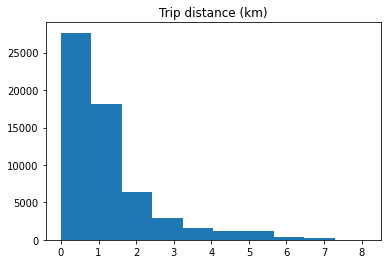

<Figure size 432x288 with 1 Axes>

In [ ]:
df = pd.read_csv('Soft-Mobility/E-Scooter_OD/wdl_od_view.csv')[['trip_id', 'event_types', 'lat', 'lng']]
df = df.loc[(df['event_types'] == '{trip_start}') | (df['event_types'] == '{trip_end}')]
distances = []
counter = 0
total = len(df['trip_id'].unique())
for trip_id in df['trip_id'].unique():
    trip_start = df.loc[(df['trip_id'] == trip_id)&(df['event_types'] == '{trip_start}')]
    trip_end = df.loc[(df['trip_id'] == trip_id)&(df['event_types'] == '{trip_end}')]
    if len(trip_start) == 1 and len(trip_end) == 1:
        start = (trip_start['lat'].item(), trip_start['lng'].item())
        end = (trip_end['lat'].item(), trip_end['lng'].item())
        dist = hs.haversine(start, end)
        distances.append(dist)
    counter += 1
    print(f'{counter} of {total}', end='\r')
distances = np.array(distances)

plt.hist(distances) 
plt.title("Trip distance (km)") 
plt.show()

**Conlcusion**: Distances are squewed to the left, which means the most of trips were of low distance. Because of that we'll set a minimum radius between zones as the 1st quartil of distances

In [ ]:
radius = np.quantile(distances, q=0.25) * 1000
print(f'Radius: {round(radius,2)}m')

Radius: 403.34m


**Creating distances matrix (between zones)**

In [ ]:
# calculating distance matrix
distances_matrix = pd.DataFrame(score_grid["zone"])
distances_matrix.sort_values(by="zone", ascending=True, inplace=True)

aux = centroids.copy()
aux.sort_values(by="zone", ascending=True, inplace=True)

counter = 0
total = len(aux)
for zone in aux.itertuples():
    center = zone.geometry
    distances = aux.geometry.distance(center)
    distances_matrix[str(zone.zone)] = distances
    counter += 1
    print(f'{counter} of {total}', end='\r')

**Finding zone radius**

In [ ]:
new_distances_matrix = distances_matrix.copy()
new_distances_matrix.iloc[:,1:] = new_distances_matrix.iloc[:,1:].mul(100000)

zones = new_distances_matrix[["zone"]]
counter = 0
#start = time.time()
all_zones_radius = []
for zone in zones.itertuples():
    zone_id = zone.zone
    zone_distances = new_distances_matrix[["zone", str(zone_id)]]
    zone_distances = zone_distances[zone_distances["zone"] != zone_id] # remove own zone
    #zone_distances.sort_values(by=str(zone_id), ascending=True, inplace=True)
    zones_plys = score_grid[["zone", "geometry"]]
    
    radius_df = zone_distances[zone_distances[str(zone_id)]<= radius]
    all_zones_radius.append(list(radius_df['zone']))
    
    counter += 1
    #end = time.time()
    #elapsed = round((end-start)/60, 2)
    elpased = 0
    print(f'{counter} of 7496 | run time: {elapsed}min | estimated time: {round(7496/counter *elapsed, 2)}min', end='\r')

score_grid.sort_values(by='zone', ascending=True, inplace=True)
score_grid['radius'] = all_zones_radius

<AxesSubplot:>

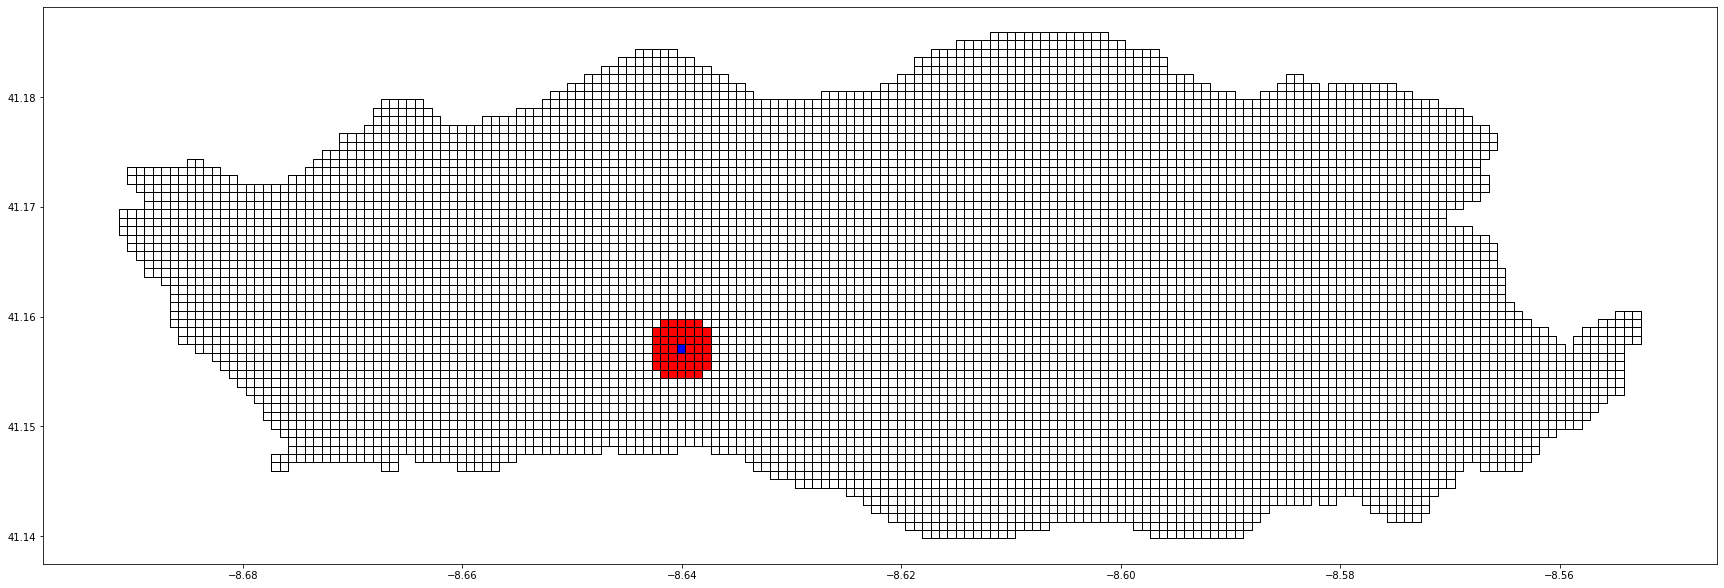

<Figure size 2160x1440 with 1 Axes>

In [ ]:
# check in map any zone
zone = 2345
df = score_grid[score_grid['zone'] == zone]
aux_1 = score_grid.loc[score_grid['zone'].isin(df.iloc[0]['radius'])]
aux_2 = score_grid[score_grid['zone']==zone]
fig, ax = plt.subplots(figsize=(30, 20))
ax.set_aspect('equal')
score_grid.plot(ax=ax, color='white', edgecolor='black')
aux_1.plot(ax=ax, color='red', edgecolor='black')
aux_2.plot(ax=ax, color='blue', edgecolor='black')
radius_grid = score_grid[['zone', 'geometry', 'n_stops', 'radius', 'score']]

### ***7. Optimization model*** <a name="opt_model"></a>

A PuLP linear optimization model was built to maximize the total score of the city (sum of scores of zones with drop-offs). To make sure the drop-offs are spread across the city, the model was restricted by a minimum number of drop-offs per parish and a maximum number of drop-offs in a certain radius based on the most travelled distances by scooter.

In [ ]:
df_to_optimize = radius_grid.copy()
df_to_optimize = df_to_optimize.merge(score_grid[['zone', 'parish']], on='zone', how='left') 
df_to_optimize

,zone,geometry,n_stops,radius,score,parish
0,0,"POLYGON ((-8.69129 41.16747, -8.69052 41.16747...",0,"[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, ...",-5.939533,4
1,1,"POLYGON ((-8.69129 41.16824, -8.69052 41.16824...",0,"[0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 23, ...",-6.101622,4
2,2,"POLYGON ((-8.69129 41.16901, -8.69052 41.16901...",0,"[0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 16, 24, 25,...",-6.744220,4
3,3,"POLYGON ((-8.69052 41.16593, -8.68975 41.16593...",0,"[0, 1, 4, 5, 6, 10, 11, 12, 13, 14, 19, 20, 21...",-6.385602,4
4,4,"POLYGON ((-8.69052 41.16670, -8.68975 41.16670...",0,"[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, ...",-4.738943,4
...,...,...,...,...,...,...
7491,7491,"POLYGON ((-8.55415 41.15978, -8.55338 41.15978...",0,"[7467, 7468, 7475, 7476, 7477, 7484, 7485, 748...",-16.140210,1
7492,7492,"POLYGON ((-8.55338 41.15747, -8.55261 41.15747...",0,"[7473, 7474, 7475, 7476, 7477, 7481, 7482, 748...",-19.339847,1
7493,7493,"POLYGON ((-8.55338 41.15824, -8.55261 41.15824...",0,"[7474, 7475, 7476, 7477, 7482, 7483, 7484, 748...",-18.013986,1
7494,7494,"POLYGON ((-8.55338 41.15901, -8.55261 41.15901...",0,"[7475, 7476, 7477, 7483, 7484, 7485, 7486, 748...",-16.724532,1


      zone                                           geometry  n_stops  \
0        0  POLYGON ((-8.69129 41.16747, -8.69052 41.16747...        0   
1        1  POLYGON ((-8.69129 41.16824, -8.69052 41.16824...        0   
2        2  POLYGON ((-8.69129 41.16901, -8.69052 41.16901...        0   
3        3  POLYGON ((-8.69052 41.16593, -8.68975 41.16593...        0   
4        4  POLYGON ((-8.69052 41.16670, -8.68975 41.16670...        0   
...    ...                                                ...      ...   
7491  7491  POLYGON ((-8.55415 41.15978, -8.55338 41.15978...        0   
7492  7492  POLYGON ((-8.55338 41.15747, -8.55261 41.15747...        0   
7493  7493  POLYGON ((-8.55338 41.15824, -8.55261 41.15824...        0   
7494  7494  POLYGON ((-8.55338 41.15901, -8.55261 41.15901...        0   
7495  7495  POLYGON ((-8.55338 41.15978, -8.55261 41.15978...        0   

                                                 radius      score  parish  
0     [1, 2, 3, 4, 5, 6, 7, 10, 11

In [ ]:
# Create the model that will maximize the usage score
print('Creating model...')
model = LpProblem(name="Scooter_stops_Section", sense=LpMaximize)

#order df_to_optimize by zone id
df_to_optimize = df_to_optimize.sort_values(by="zone", ascending=True)

# Initialize the decision variables
print('Adding decision variables...')
stops= []
for zone in df_to_optimize.itertuples():
    zone_id = zone.zone
    stops.append(LpVariable(name=str(zone_id), lowBound=0, upBound=1, cat='Binary'))

# intialize f_obj = sum(usage_score * stops in zone)
f_obj =  df_to_optimize.iloc[0]['score'] * stops[0]

#add to obj function
print('Adding objective function...')
n_zones = len(df_to_optimize)
for i in range(1,n_zones):
    f_obj +=  df_to_optimize.iloc[i]['score'] * stops[i] 
    
# add obj funtion to model
model += f_obj

print('Adding contstraints...')
# add proximity contstraints (zones in same radius) cant be together)
for zone in df_to_optimize.itertuples():
    zone_id = zone.zone
    model += (lpSum(stops[i] for i in zone.radius) <= 1, f"max_radius_{zone_id}")

# add total stops constraints
model += (lpSum(stops) <= 210)

# add total stops per parish contraint
for parish in porto.itertuples():
    model += (lpSum(stops[i] for i in parish.zones) >= min_stops, f"min_stops_{parish.title}")

#Optimize model
print('Solving model...')
status = model.solve()

Creating model...
Adding decision variables...
Adding objective function...
Adding contstraints...
Solving model...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/pq/vs_mpvbj7677j7s11l_m3r380000gn/T/9535eacc02d44e63909854ecb2e70221-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/pq/vs_mpvbj7677j7s11l_m3r380000gn/T/9535eacc02d44e63909854ecb2e70221-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7509 COLUMNS
At line 358712 RHS
At line 366217 BOUNDS
At line 373714 ENDATA
Problem MODEL has 7504 rows, 7496 columns and 328714 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1100.57 - 0.72 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1659 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 916 strengthen

In [ ]:
## Merge Results with Dataset
new_df = pd.DataFrame(df_to_optimize['zone'])
results = []
names = []
for var in model.variables():
    results.append(var.value())
    names.append(int(var.name))

new_df['names'] = names
new_df['new_stops'] = results
new_df['zone'] = names

final_df = df_to_optimize.merge(new_df, how='left', on='zone')

# Stops removed: 202
# Stops mantained: 8
# New Stops: 96
# Total Current Stops: 104.0




<AxesSubplot:>

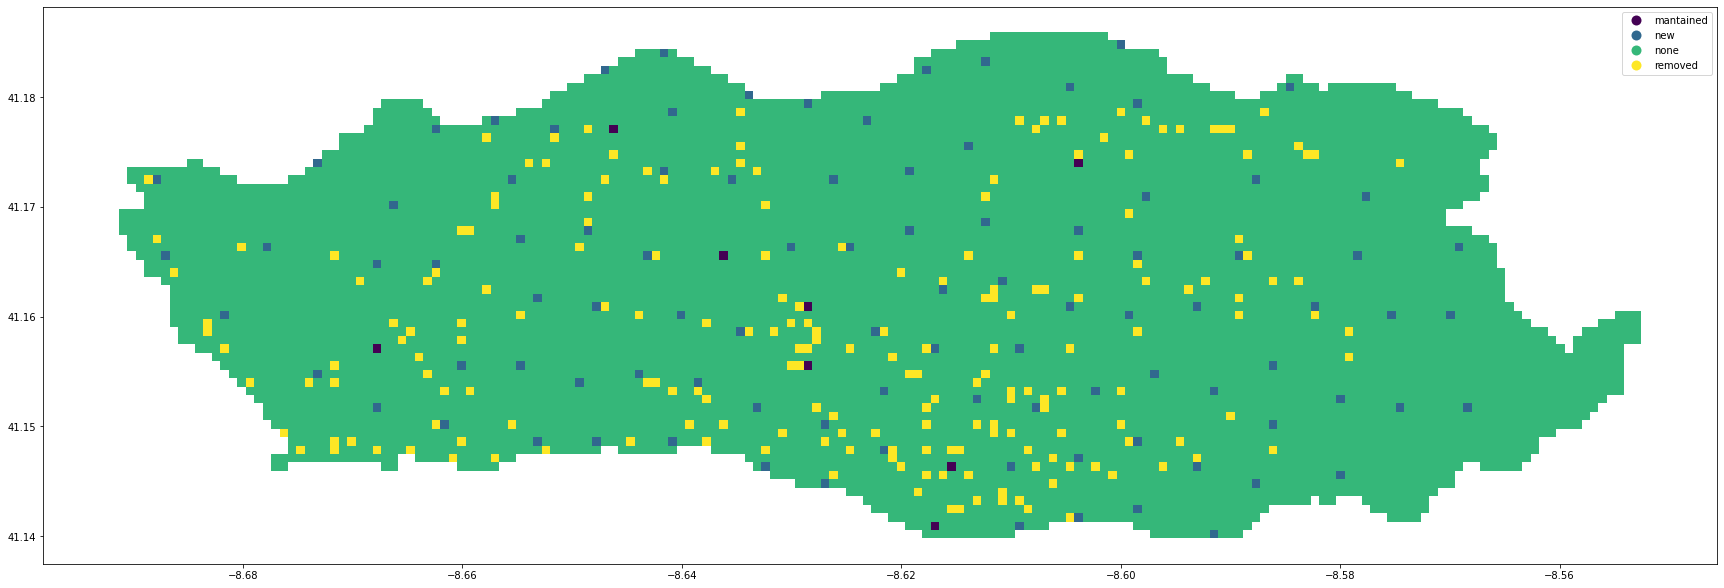

<Figure size 2160x1440 with 1 Axes>

In [ ]:
types = []
for i, row in final_df.iterrows():
    if row['n_stops'] == 0:
        if row['new_stops'] == 1:
            types.append('new')
        else:
            types.append('none')
    else:
        if row['new_stops'] == 1:
            types.append('mantained')
        else:
            types.append('removed')
final_df['difference'] = types
print(f"# Stops removed: {final_df[final_df['difference'] == 'removed']['difference'].count()}")
print(f"# Stops mantained: {final_df[final_df['difference'] == 'mantained']['difference'].count()}")
print(f"# New Stops: {final_df[final_df['difference'] == 'new']['difference'].count()}")
print(f"# Total Current Stops: {final_df['new_stops'].sum()}")
final_df.plot(figsize=(30, 20), column="difference", cmap="viridis", categorical=True, legend = True)

**Populating with remaining drop-off**

the model was only able to insert 100 stops in the model, there are 110 stops to input left.
to populate the remaining stops we can insert by radius score

In [ ]:
# calculating radius score
total_scores = []
for zone in final_df.itertuples():
    aux = final_df[final_df['zone'].isin(zone.radius)]
    score = aux.score.sum()
    total_scores.append(score)

final_df['radius_score'] = total_scores
final_df.sort_values(by='score', ascending=False, inplace = True)

for zone in final_df.itertuples():
    if final_df.new_stops.sum() == 210:
        break
    if zone.new_stops < 1: 
        aux = final_df[final_df['zone'].isin(zone.radius)]   
        if aux.new_stops.sum() <= 2:
            final_df.at[zone.zone, 'new_stops'] = 1

,zone,geometry,n_stops,radius,score,parish,names,new_stops,difference,radius_score
4363,4363,"POLYGON ((-8.60962 41.15209, -8.60885 41.15209...",0,"[4182, 4183, 4184, 4185, 4186, 4241, 4242, 424...",51.462242,5,4363,1.0,none,979.326508
4362,4362,"POLYGON ((-8.60962 41.15132, -8.60885 41.15132...",0,"[4181, 4182, 4183, 4184, 4185, 4240, 4241, 424...",40.848656,5,4362,1.0,none,959.557344
3028,3028,"POLYGON ((-8.62888 41.16055, -8.62811 41.16055...",1,"[2889, 2890, 2891, 2892, 2893, 2933, 2934, 293...",37.986871,5,3028,1.0,mantained,859.779495
5170,5170,"POLYGON ((-8.59884 41.14824, -8.59807 41.14824...",0,"[4997, 4998, 4999, 5000, 5001, 5053, 5054, 505...",37.423134,0,5170,1.0,new,447.870243
4304,4304,"POLYGON ((-8.61039 41.15209, -8.60962 41.15209...",1,"[4123, 4124, 4125, 4126, 4127, 4181, 4182, 418...",34.549238,5,4304,0.0,removed,1008.991251
...,...,...,...,...,...,...,...,...,...,...
7478,7478,"POLYGON ((-8.55492 41.15286, -8.55415 41.15286...",0,"[7449, 7450, 7451, 7452, 7453, 7459, 7460, 746...",-22.839944,1,7478,0.0,none,-347.303932
7438,7438,"POLYGON ((-8.55801 41.15055, -8.55724 41.15055...",0,"[7408, 7409, 7410, 7411, 7418, 7419, 7420, 742...",-22.840716,1,7438,0.0,none,-441.602431
7459,7459,"POLYGON ((-8.55647 41.15209, -8.55569 41.15209...",0,"[7428, 7429, 7430, 7431, 7432, 7438, 7439, 744...",-22.923477,1,7459,0.0,none,-501.802466
7427,7427,"POLYGON ((-8.55878 41.14978, -8.55801 41.14978...",0,"[7396, 7397, 7398, 7399, 7408, 7409, 7410, 741...",-23.285850,1,7427,0.0,none,-400.623808


      zone                                           geometry  n_stops  \
4363  4363  POLYGON ((-8.60962 41.15209, -8.60885 41.15209...        0   
4362  4362  POLYGON ((-8.60962 41.15132, -8.60885 41.15132...        0   
3028  3028  POLYGON ((-8.62888 41.16055, -8.62811 41.16055...        1   
5170  5170  POLYGON ((-8.59884 41.14824, -8.59807 41.14824...        0   
4304  4304  POLYGON ((-8.61039 41.15209, -8.60962 41.15209...        1   
...    ...                                                ...      ...   
7478  7478  POLYGON ((-8.55492 41.15286, -8.55415 41.15286...        0   
7438  7438  POLYGON ((-8.55801 41.15055, -8.55724 41.15055...        0   
7459  7459  POLYGON ((-8.55647 41.15209, -8.55569 41.15209...        0   
7427  7427  POLYGON ((-8.55878 41.14978, -8.55801 41.14978...        0   
7469  7469  POLYGON ((-8.55569 41.15286, -8.55492 41.15286...        0   

                                                 radius      score  parish  \
4363  [4182, 4183, 4184, 4185, 41

# Stops removed: 197
# Stops mantained: 13
# New Stops: 197
# Total Current Stops: 210.0




<AxesSubplot:>

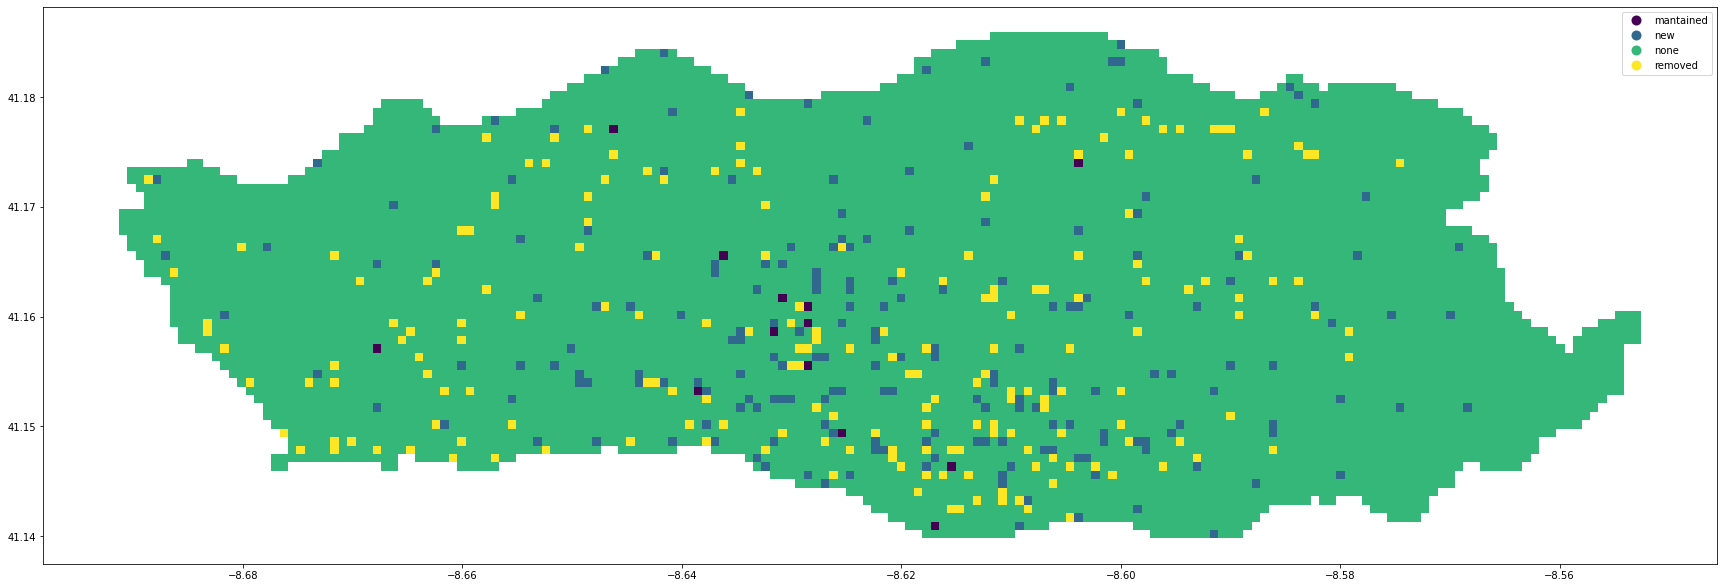

<Figure size 2160x1440 with 1 Axes>

In [ ]:
types = []
for i, row in final_df.iterrows():
    if row['n_stops'] == 0:
        if row['new_stops'] == 1:
            types.append('new')
        else:
            types.append('none')
    else:
        if row['new_stops'] == 1:
            types.append('mantained')
        else:
            types.append('removed')
final_df['difference'] = types
print(f"# Stops removed: {final_df[final_df['difference'] == 'removed']['difference'].count()}")
print(f"# Stops mantained: {final_df[final_df['difference'] == 'mantained']['difference'].count()}")
print(f"# New Stops: {final_df[final_df['difference'] == 'new']['difference'].count()}")
print(f"# Total Current Stops: {final_df['new_stops'].sum()}")
final_df.plot(figsize=(30, 20), column="difference", cmap="viridis", categorical=True, legend = True)

## 🛠️ Product  <a name="product"></a>
### Definition
A data-driven decision support system for optimization of soft-mobility drop-off zones in order to maximize the usage of these solutions by the population.

### Users
Porto's management departments for transportation and mobility, when deciding the drop-off zones for the e-scooters.

### Activities
Our solution:
* Predicts scores combining factors that influence the usage of soft-mobility solutions.
* Suggests optimal drop-off points maximizing the usage of the e-scooters.

### Output
A data-driven dashboard that consists of two tabs:

First, the dashboard allows the user to choose a weight for each feature. These weights can be either provided by our classification model or defined by the user based on domain expertise and/or the municipality’s goals. After setting the weights, each zone is assigned a score reflecting the likelihood of that specific location successfully maximizing the usage by the population.

![Dashboard1](https://i.imgur.com/p4mq2oY.png)

Then, an optimization model suggests optimal drop-off points that will maximize these scores, given the problem constraints, which can also be manipulated by the user. You can watch the full demo ***[here](https://www.youtube.com/watch?v=TTKaWskbGfQ)***.

![Dashboard2](https://i.imgur.com/m8w5pEC.png)

If the cost of moving around the drop-off zones is acceptable for the municipality, we strongly advise that this process is repeated from time to time, with the most recent data on soft-mobility trips, since we believe that the model will capture seasonal trends. For instance, during the Winter, the distance to the nearest tourist attraction might have less impact on the score than during the peak season as there is less flow of tourists.

In conclusion, we offer an interactive, flexible, and dynamic solution that helps maximize the usage of the e-scooters throughout the whole year.

### ***8. Impact Estimation*** <a name="impact"></a>

The estimated increase in usage will be calculated by the median number of trips of "high" labeled stops and the median number of trips of "low" labeled stops

In [ ]:
median_low = 53
median_high = 354

labels = pd.read_csv("zones_labels.csv")
final_df = final_df.merge(labels, how="left", on="zone")

,zone,geometry,n_stops,radius,score,parish,names,new_stops,difference,radius_score,label
0,4363,"POLYGON ((-8.60962 41.15209, -8.60885 41.15209...",0,"[4182, 4183, 4184, 4185, 4186, 4241, 4242, 424...",51.462242,5,4363,1.0,new,979.326508,0
1,4362,"POLYGON ((-8.60962 41.15132, -8.60885 41.15132...",0,"[4181, 4182, 4183, 4184, 4185, 4240, 4241, 424...",40.848656,5,4362,1.0,new,959.557344,0
2,3028,"POLYGON ((-8.62888 41.16055, -8.62811 41.16055...",1,"[2889, 2890, 2891, 2892, 2893, 2933, 2934, 293...",37.986871,5,3028,1.0,mantained,859.779495,1
3,5170,"POLYGON ((-8.59884 41.14824, -8.59807 41.14824...",0,"[4997, 4998, 4999, 5000, 5001, 5053, 5054, 505...",37.423134,0,5170,1.0,new,447.870243,0
4,4304,"POLYGON ((-8.61039 41.15209, -8.60962 41.15209...",1,"[4123, 4124, 4125, 4126, 4127, 4181, 4182, 418...",34.549238,5,4304,0.0,removed,1008.991251,1
...,...,...,...,...,...,...,...,...,...,...,...
7491,7478,"POLYGON ((-8.55492 41.15286, -8.55415 41.15286...",0,"[7449, 7450, 7451, 7452, 7453, 7459, 7460, 746...",-22.839944,1,7478,0.0,none,-347.303932,0
7492,7438,"POLYGON ((-8.55801 41.15055, -8.55724 41.15055...",0,"[7408, 7409, 7410, 7411, 7418, 7419, 7420, 742...",-22.840716,1,7438,0.0,none,-441.602431,0
7493,7459,"POLYGON ((-8.55647 41.15209, -8.55569 41.15209...",0,"[7428, 7429, 7430, 7431, 7432, 7438, 7439, 744...",-22.923477,1,7459,0.0,none,-501.802466,0
7494,7427,"POLYGON ((-8.55878 41.14978, -8.55801 41.14978...",0,"[7396, 7397, 7398, 7399, 7408, 7409, 7410, 741...",-23.285850,1,7427,0.0,none,-400.623808,0


      zone                                           geometry  n_stops  \
0     4363  POLYGON ((-8.60962 41.15209, -8.60885 41.15209...        0   
1     4362  POLYGON ((-8.60962 41.15132, -8.60885 41.15132...        0   
2     3028  POLYGON ((-8.62888 41.16055, -8.62811 41.16055...        1   
3     5170  POLYGON ((-8.59884 41.14824, -8.59807 41.14824...        0   
4     4304  POLYGON ((-8.61039 41.15209, -8.60962 41.15209...        1   
...    ...                                                ...      ...   
7491  7478  POLYGON ((-8.55492 41.15286, -8.55415 41.15286...        0   
7492  7438  POLYGON ((-8.55801 41.15055, -8.55724 41.15055...        0   
7493  7459  POLYGON ((-8.55647 41.15209, -8.55569 41.15209...        0   
7494  7427  POLYGON ((-8.55878 41.14978, -8.55801 41.14978...        0   
7495  7469  POLYGON ((-8.55569 41.15286, -8.55492 41.15286...        0   

                                                 radius      score  parish  \
0     [4182, 4183, 4184, 4185, 41

In [ ]:
old = final_df[final_df['difference'] != 'new']
total_old_usage = len(old[old['label'] == 0]) *  median_low + len(old[old['label'] == 1]) *  median_high

new = final_df[final_df['difference'] != 'old']
total_new_usage = len(new[new['label'] == 0]) *  median_low + len(new[new['label'] == 1]) *  median_high

print(f'Old Usage: {total_old_usage}')
print(f'New Usage: {total_new_usage}')
print(f'Improvement (%): {round((total_new_usage - total_old_usage)/total_old_usage * 100, 2)}%')
print(f'Improvement (abs): {total_new_usage - total_old_usage}')

Old Usage: 424171
New Usage: 434913
Improvement (%): 2.53%
Improvement (abs): 10742


Our model estimates an increase on scooter trips by 2,53%.

### ***9. Additional EDA*** <a name="more_eda"></a>

#### Ratio between trips and validation

What is the ration between the number of trips started in a zone and the number of validations in metro and bus in that zone?

Open grid with number of scooter trips per zone and filter for zones with at least 1 metro stop and 1 bus stop.

In [ ]:
df = pd.read_csv('aux_grid_with_scooter_trips.csv')
df = df.loc[(df['n_metro']>0) & (df['n_bus']>0)][['zone', 'validations_metro', 'validations_bus', 'n_trips_start']]
df.head()

,zone,validations_metro,validations_bus,n_trips_start
1992,1992,2007.755646,271.025974,97.0
2271,2271,1714.964587,54.197902,0.0
4239,4239,2224.885381,424.500000,17.0
4410,4410,1509.117790,11.583681,5.0
5170,5170,4321.975397,154.792589,10.0


      zone  validations_metro  validations_bus  n_trips_start
1992  1992        2007.755646       271.025974           97.0
2271  2271        1714.964587        54.197902            0.0
4239  4239        2224.885381       424.500000           17.0
4410  4410        1509.117790        11.583681            5.0
5170  5170        4321.975397       154.792589           10.0

Compute average number of validations per zone and then te ratio between that value and the number of scooter trips.

In [ ]:
df['avg_validations'] = (df['validations_metro'] + df['validations_bus']) / 2
df = df[['zone', 'avg_validations', 'n_trips_start']]
df['ratio'] = (df['n_trips_start'] / df['avg_validations']) * 100
df.head()

,zone,avg_validations,n_trips_start,ratio
1992,1992,1139.390810,97.0,8.513321
2271,2271,884.581245,0.0,0.000000
4239,4239,1324.692691,17.0,1.283317
4410,4410,760.350736,5.0,0.657591
5170,5170,2238.383993,10.0,0.446751


      zone  avg_validations  n_trips_start     ratio
1992  1992      1139.390810           97.0  8.513321
2271  2271       884.581245            0.0  0.000000
4239  4239      1324.692691           17.0  1.283317
4410  4410       760.350736            5.0  0.657591
5170  5170      2238.383993           10.0  0.446751

<AxesSubplot:ylabel='ratio'>

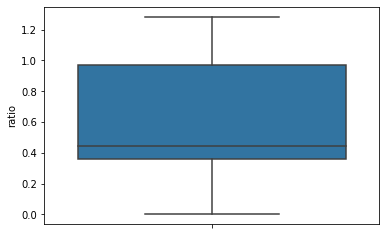

<Figure size 432x288 with 1 Axes>

In [ ]:
sns.boxplot(y='ratio', data=df, showfliers=False)

In [ ]:
print("Average ratio (%) =", df['ratio'].mean())
print("Median ratio (%) =", df['ratio'].median())
print("Max ratio (%) =", df['ratio'].max())

Average ratio (%) = 1.6593017872231155
Median ratio (%) = 0.4467508716417795
Max ratio (%) = 8.513321254798
